In [92]:
from astropy import units
from astropy.stats import gaussian_fwhm_to_sigma
import matplotlib.pyplot as plt
#plt.style.use('my_style')
import numpy as np

In [93]:
def integrate(theta, phi, integrand):
    theta = units.Quantity(theta, unit=units.deg).to('rad')
    phi = units.Quantity(phi, unit=units.deg).to('rad')
    # very simple quadrature, assuming uniform
    # theta, phi sampling and theta major ordering
    dtheta = np.max(np.diff(theta))
    dphi = phi[1] - phi[0]
    dsa = (dtheta*dphi*np.sin(theta)).value
    return np.sum(dsa*integrand)

def sym_gaussian(theta, phi, freq, diameter, fwhm_fac=1, voltage=True, power_norm=1):
    theta = units.Quantity(theta, unit=units.deg).to('rad')
    phi = units.Quantity(phi, unit=units.deg).to('rad')
    
    diameter = units.Quantity(diameter, unit=units.m)
    wl = units.Quantity(freq, unit=units.MHz).to('m', equivalencies=units.spectral())
    
    fwhm = (fwhm_fac * wl/diameter).to('rad', equivalencies=units.dimensionless_angles())
    sigma = gaussian_fwhm_to_sigma*fwhm
    power_beam = np.exp(-theta**2/2/sigma**2).value
    
    power_beam *= power_norm/integrate(theta, phi, power_beam)
    
    if voltage:
        return power_beam**.5
    else:
        return power_beam
    
def quad_crosspol(theta, phi, vcopol, voltage=True, rel_power_dB=-40):
    theta = units.Quantity(theta, unit=units.deg).to('rad').value
    phi = units.Quantity(phi, unit=units.deg).to('rad').value
    
    voltage_beam = theta**2*vcopol*np.cos(2*phi + np.pi/2)
    
    copol_power = integrate(theta, phi, vcopol**2)
    power_norm = integrate(theta, phi, voltage_beam**2)
    
    voltage_beam *= (10**(rel_power_dB/10)*copol_power/power_norm)**.5
    
    if voltage:
        return voltage_beam
    else:
        return voltage_beam**2

In [94]:
# parameters
max_theta = 20*units.deg
n_theta = 180
n_phi = 360
copol_kwargs = {'freq':600*units.MHz, 'diameter': 6*units.m, 'power_norm': 1, 'voltage': True}
crpol_kwargs = {'rel_power_dB': -40, 'voltage': True}

In [95]:
theta_range = np.linspace(0, max_theta, n_theta)
phi_range = np.linspace(0, 360, n_phi, endpoint=False)*units.deg # Don't double count 0 and 360

grid_th_phi = np.meshgrid(theta_range, phi_range, indexing='ij')
theta = np.ravel(grid_th_phi[0])
phi = np.ravel(grid_th_phi[1])

In [96]:
vcopol_x = sym_gaussian(theta, phi, **copol_kwargs)
vcrpol_x = quad_crosspol(theta, phi, vcopol_x, **crpol_kwargs)

phi_y = phi + 90*units.deg # y is just 90 deg azimuthal rotation in this example
over_360 = phi_y[phi_y >= 360*units.deg]
over_360 = over_360 - 360*units.deg

vcopol_y = sym_gaussian(theta, phi_y, **copol_kwargs)
vcrpol_y = quad_crosspol(theta, phi_y, vcopol_y, **crpol_kwargs)

/tmp/ipykernel_1436105/338953556.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = XX_ax.pcolormesh(grid_th_phi[1].to('rad').value, grid_th_phi[0].value, vcopol_x.reshape(grid_th_phi[0].shape), vmin=co_vmin, vmax=co_vmax)
/tmp/ipykernel_1436105/338953556.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = XY_ax.pcolormesh(grid_th_phi[1].to('rad').value, grid_th_phi[0].value, vcrpol_x.reshape(grid_th_phi[0].shape), vmin=cr_vmin, vmax=cr_vmax)
/t

<Figure size 648x288 with 0 Axes>

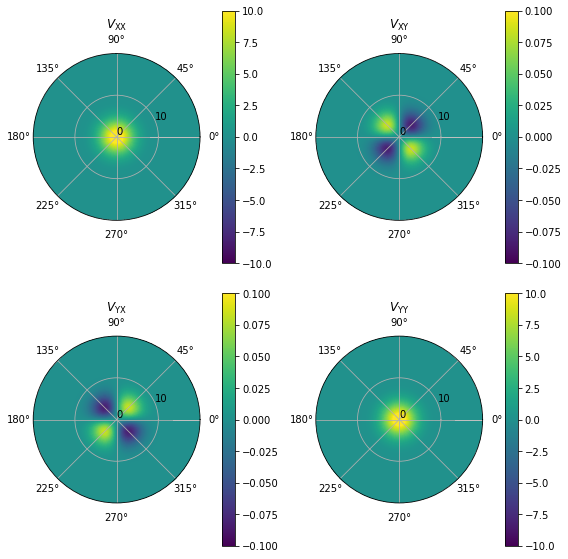

In [97]:
fig = plt.figure(figsize=(9, 4))

co_vmin, co_vmax = -10, 10
cr_vmin, cr_vmax = -1e-1, 1e-1

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(8, 8))

XX_ax, XY_ax, YX_ax, YY_ax = axs.flat

for ax in axs.flat:
    ax.set_rticks(np.arange(0, max_theta.value, 10))
    ax.grid(False) # For deprecation warning

XX_ax.set_title(r'$V_{\rm XX}$')
XY_ax.set_title(r'$V_{\rm XY}$')
YX_ax.set_title(r'$V_{\rm YX}$')
YY_ax.set_title(r'$V_{\rm YY}$')

im = XX_ax.pcolormesh(grid_th_phi[1].to('rad').value, grid_th_phi[0].value, vcopol_x.reshape(grid_th_phi[0].shape), vmin=co_vmin, vmax=co_vmax)
plt.colorbar(im, ax=XX_ax, pad=0.1)
im = XY_ax.pcolormesh(grid_th_phi[1].to('rad').value, grid_th_phi[0].value, vcrpol_x.reshape(grid_th_phi[0].shape), vmin=cr_vmin, vmax=cr_vmax)
plt.colorbar(im, ax=XY_ax, pad=0.1)

im = YY_ax.pcolormesh(grid_th_phi[1].to('rad').value, grid_th_phi[0].value, vcopol_y.reshape(grid_th_phi[0].shape), vmin=co_vmin, vmax=co_vmax)
plt.colorbar(im, ax=YY_ax, pad=0.1)
im = YX_ax.pcolormesh(grid_th_phi[1].to('rad').value, grid_th_phi[0].value, vcrpol_y.reshape(grid_th_phi[0].shape), vmin=cr_vmin, vmax=cr_vmax)
plt.colorbar(im, ax=YX_ax, pad=0.1)
for ax in axs.flat:
    ax.grid(True)
fig.tight_layout()

In [98]:
header = """Theta [deg]
Phi [deg]
Abs dir *
Abs Horiz.
Phase Horiz. [deg]
Abs Vert.
Phase Vert. [deg]
Ax. ratio *""".split('\n')
header

['Theta [deg]',
 'Phi [deg]',
 'Abs dir *',
 'Abs Horiz.',
 'Phase Horiz. [deg]',
 'Abs Vert.',
 'Phase Vert. [deg]',
 'Ax. ratio *']

In [99]:
out_header = ''.join([f'{it:>20s}' for it in header])
out_header += '\n' + '-'*len(out_header)

data_x = np.column_stack([
    theta.value,                  # Theta [deg]
    phi.value,                    # Phi [deg]
    np.zeros_like(theta).value,   # Abs dir * / Unused
    np.abs(vcopol_x),             # Abs horizontal
    np.angle(vcopol_x, deg=True), # Phase horizontal [deg]
    np.abs(vcrpol_x),             # Abs vertical
    np.angle(vcrpol_x, deg=True), # Phase vertical [deg]
    np.zeros_like(theta).value,   # Ax. ratio * / Unused   
])

data_y = np.column_stack([
    theta.value,                  # Theta [deg]
    phi.value,                    # Phi [deg]
    np.zeros_like(theta).value,   # Abs dir * / Unused
    np.abs(vcrpol_y),             # Abs horizontal
    np.angle(vcrpol_y, deg=True), # Phase horizontal [deg]
    np.abs(vcopol_y),             # Abs vertical
    np.angle(vcopol_y, deg=True), # Phase vertical [deg]
    np.zeros_like(theta).value,   # Ax. ratio * / Unused
])

np.savetxt('/home/rohit/simulations/primary_beam/cst_like_beam_port_1.txt', # X polarised (port 1) (Co=H)
           X=data_x, header=out_header,
           fmt='%20e', comments='', delimiter='')

np.savetxt('/home/rohit/simulations/primary_beam/cst_like_beam_port_2.txt', # Y polarised (port 2) (Co=V)
           X=data_y, header=out_header,
           fmt='%20e', comments='', delimiter='')

In [100]:
!head -n 30 cst_like_beam_port_1.txt

head: cannot open 'cst_like_beam_port_1.txt' for reading: No such file or directory


In [101]:
(np.abs(vcrpol_y)/np.max(vcrpol_y).max()).max()


1.0